In [261]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from nltk.tokenize import word_tokenize 
import pandas as pd
import numpy as np
import seaborn as sns
import random
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from nltk.corpus import stopwords


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


%matplotlib inline

# Import data

In [2]:
main_df = pd.read_csv('data/apple_goog.csv', index_col=0)

In [3]:
main_df = main_df.drop_duplicates(subset='c_tweet', keep="first")

# remove rogue nan value in the tweets
main_df.drop(main_df.index[40395], inplace=True)

In [4]:
main_df.shape

(459852, 8)

# Tagging sentiment of each tweet

In [5]:
analyzer = SentimentIntensityAnalyzer()

def sentiment_analyzer_scores(sentence):

    score = analyzer.polarity_scores(sentence)
    

    if score['compound'] >= .05:
        sent = 'positive'
    
    elif score['compound'] <= -.05:
        sent = 'negative'
       
    else:
        sent = 'neutral'
        

    return sent

In [6]:
main_df['sentiment'] = main_df.c_tweet.apply(sentiment_analyzer_scores)

In [7]:
main_df.head(5)

,date,name,username,retweets_count,search_term,likes_count,language,c_tweet,sentiment
1,2020-11-28,HyperNavJack27,jack_mangano,0,apple silicon,10,en,borderlands in on apple silicon yes yes it pla...,positive
4,2020-11-28,Erik Engheim,erikengheim,0,apple silicon,1,en,mac mini vs mac pro interesting review of pros...,positive
5,2020-11-28,Armando Monroy,ratzo,0,apple silicon,2,en,and can only imagine what the apple silicon fo...,positive
7,2020-11-28,Matthew S. Smith,matt_on_tech,1,apple silicon,4,en,to repeat something said at the debut if apple...,neutral
10,2020-11-28,Danel Omen ➐ he/him.®️,heck_wtf,0,apple silicon,0,en,is not the problem pixel size is the problem a...,negative


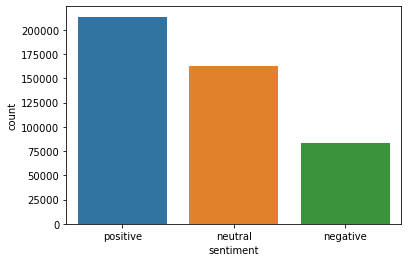

In [8]:
sns.countplot('sentiment', data=main_df);

# Seperate Dataframes by company

In [9]:
app_sil_df = main_df[main_df.search_term=="apple silicon"]
google_pixel_5_df = main_df[main_df.search_term=="google pixel 5"]
m1_macbook_df = main_df[main_df.search_term=="M1 macbook"]
new_macbook_df = main_df[main_df.search_term=="new macbook"]
new_pixel_df = main_df[main_df.search_term=="new pixel"]
pixel_5_df = main_df[main_df.search_term=="pixel 5"]
iphone_12_df = main_df[main_df.search_term=="iphone 12"]

In [10]:
app_frames = [app_sil_df,
m1_macbook_df,
new_macbook_df,
iphone_12_df]

goo_frames = [google_pixel_5_df,
new_pixel_df,
pixel_5_df]

apple_df = pd.concat(app_frames, ignore_index = True)
google_df = pd.concat(goo_frames, ignore_index = True)

In [11]:
apple_df['date'] = pd.to_datetime(apple_df['date'])
google_df['date'] = pd.to_datetime(google_df['date'])

In [12]:
apple_by_day = apple_df.groupby('date')['sentiment'].value_counts(normalize=True).unstack()
google_by_day = google_df.groupby('date')['sentiment'].value_counts(normalize=True).unstack()

In [13]:
monthly_sentiment = apple_df.groupby(apple_df['date'].dt.strftime('%B'))['sentiment'].value_counts() #sum().sort_values()

In [14]:
monthly_sentiment = pd.DataFrame(monthly_sentiment)

In [15]:
monthly_sentiment

sentiment
date      sentiment           
December  positive         769
          neutral          457
          negative         228
November  positive       76292
          neutral        54204
          negative       27979
October   positive       91266
          neutral        75684
          negative       36827
September positive       17285
          neutral        16482
          negative        9652

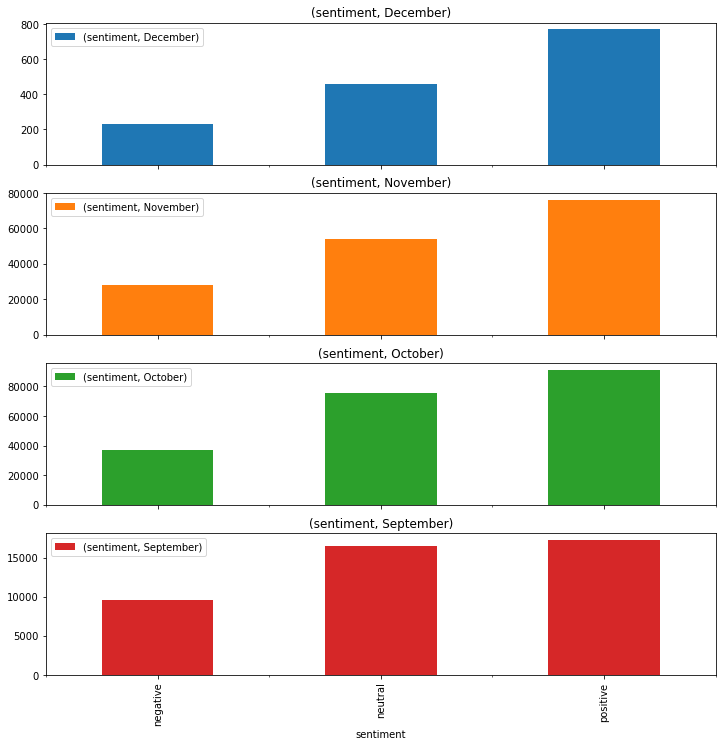

In [16]:
monthly_sentiment.unstack(level=0).plot(kind='bar', subplots=True, figsize=(12,12));

In [17]:
multi = apple_df.set_index(['date', 'sentiment'])

In [18]:
# multi.groupby(multi.date.dt.strftime('%B'))['sentiment'].value_counts()
# monthly_sentiment = pd.DataFrame(monthly_sentiment)

In [19]:
multi

name        username  retweets_count  \
date       sentiment                                                           
2020-11-28 positive           HyperNavJack27    jack_mangano               0   
           positive             Erik Engheim     erikengheim               0   
           positive           Armando Monroy           ratzo               0   
           neutral          Matthew S. Smith    matt_on_tech               1   
           negative   Danel Omen ➐ he/him.®️        heck_wtf               0   
...                                      ...             ...             ...   
2020-09-01 negative                 Chihibot        chihibot               0   
           negative                    Yuyo™   alacraneros47               0   
           neutral      Grégory Thiell 🧢🌿🚗⚡️         gthiell               0   
           neutral               ずみ@zoomishi        zoomishi               0   
           neutral         YT Vince Montiero  vince_montiero               0   

                        search_term  likes_count language  \
date       sentiment                                        
2020-11-28 positive   apple silicon           10       en   
           positive   apple silicon            1       en   
           positive   apple silicon            2       en   
           neutral    apple silicon            4       en   
           negative   apple silicon            0       en   
...                             ...          ...      ...   
2020-09-01 negative       iphone 12            0       en   
           negative       iphone 12            0       en   
           neutral        iphone 12            0       en   
           neutral        iphone 12            0       en   
           neutral        iphone 12            0       en   

                                                                c_tweet  
date       sentiment                                                     
2020-11-28 positive   borderlands in on apple silicon yes yes it pla...  
           positive   mac mini vs mac pro interesting review of pros...  
           positive   and can only imagine what the apple silicon fo...  
           neutral    to repeat something said at the debut if apple...  
           negative   is not the problem pixel size is the problem a...  
...                                                                 ...  
2020-09-01 negative   new restoration project coming on sunday ll fi...  
           negative   drop the new iphone already phone less face wi...  
           neutral    ll upgrade my iphone pro max to iphone if they...  
           neutral    rumor airtags could launch alongside iphone in...  
           neutral    if your money is unlimited what would you buy ...  

[407125 rows x 7 columns]

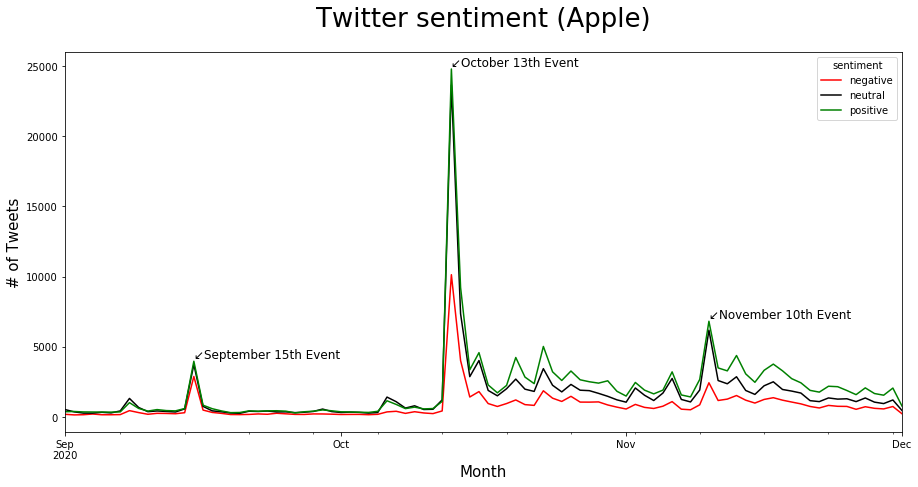

In [20]:
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
multi.groupby(['date','sentiment']).count()['c_tweet'].unstack().plot(ax=ax,color=('red','black', 'green'));

ax.annotate("↙September 15th Event", xy=(pd.Timestamp('2020-9-15'), 4200), fontsize=12)
ax.annotate("↙October 13th Event", xy=(pd.Timestamp('2020-10-13'), 25000), fontsize=12)
ax.annotate("↙November 10th Event", xy=(pd.Timestamp('2020-11-10'), 7000), fontsize=12)
#fig.subplots_adjust(top=0.75)
plt.xlabel('Month', size=15) 
plt.ylabel('# of Tweets', size=15)
ax.set_title('Twitter sentiment (Apple)', fontsize=26, pad='25.0');

In [21]:
# Apple Event Sep 15.
# Streamed live on Sep 15, 2020
#latest updates for Apple Watch, iPad Air, and more.

# --------------------

# Apple event: latest updates for HomePod mini, iPhone, and more. 
#  Oct 13, 2020
# https://www.youtube.com/watch?v=KR0g-1hnQPA

#-----------------

# Apple 'one more thing' event. M1 Chip etc. 
# Streamed live on Nov 10, 2020
# https://www.youtube.com/watch?v=5AwdkGKmZ0I


# Google monthly sentiment

In [22]:
multi = apple_df.set_index(['date', 'sentiment'])

In [23]:
google_multi = google_df.set_index(['date', 'sentiment'])

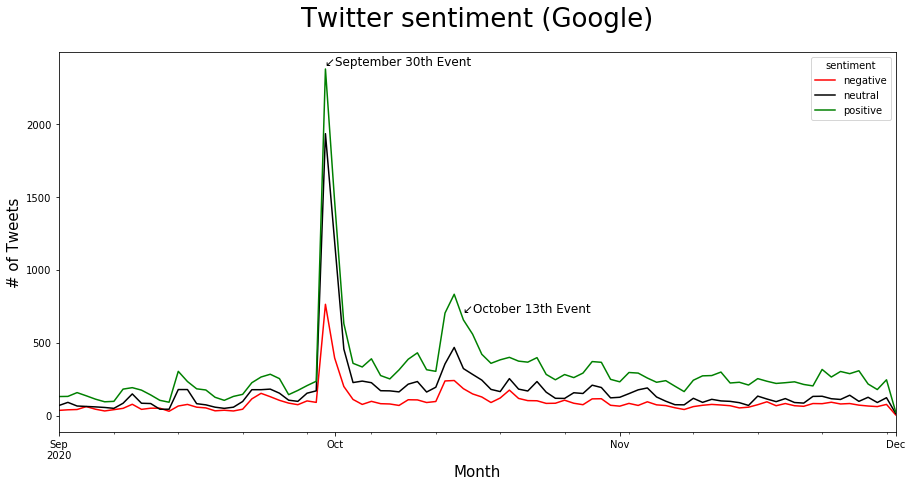

In [24]:
fig, ax = plt.subplots(figsize=(15,7))
google_multi.groupby(['date','sentiment']).count()['c_tweet'].unstack().plot(ax=ax,color=('red','black', 'green'));
ax.annotate("↙September 30th Event", xy=(pd.Timestamp('2020-9-30'), 2400), fontsize=12)
ax.annotate("↙October 13th Event", xy=(pd.Timestamp('2020-10-15'), 710), fontsize=12)
plt.xlabel('Month', size=15) 
plt.ylabel('# of Tweets', size=15)
ax.set_title('Twitter sentiment (Google)', fontsize=26, pad='25.0');


In [25]:
# October 13th - Google Has hardware event
# https://www.androidcentral.com/everything-you-can-expect-google-october-15-hardware-event


# September 30th Pixel 5 Event
#https://techcrunch.com/2020/09/30/watch-googles-pixel-5-event-live-right-here/?guccounter=1&guce_referrer=aHR0cHM6Ly93d3cuZ29vZ2xlLmNvbS8&guce_referrer_sig=AQAAAHmVz7Vlrdb6BLQ5H0ewKvlDfrWdnL6N_1VIcbQc3iRyxohZUekwceMcQ5Y7w6tKyLCSNXFkpxMTmce2eOIxfwBYy4qxa2VwzifgU3Ewrmr3Y3E3JOhhWMJGYga5Y140jWYYb4zFqIMRX9WAilifirdDl3QAqZfbsvzAvkZwLEIH


# Stop Words

In [26]:
nltk.download('stopwords')

stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brendanferris/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [27]:
stop_words=list(set(stopwords.words("english")))

In [28]:
stop_words.extend(["ll", "please retweet", "help rt", "visit us", "please subscribe", "for sale", "enter here", "to win", "from iphone", "huge giveaway", "new arrival", "win an", "unlocked now", "new available", "giveaway", "subscribe", "retweet", "easter egg"])

In [29]:
eda_stopwords = ["iphone", "iphone pro", "pro max", "youtube", "youtuber", "youtubers", 
                 "also", "asap", "hmmm","hello", "haha", "dont", "imac", "ipad", 
                 "ipadair", "ipads", "iphonecase", "iphonemini", "iphonepro", "iphonepromax", 
                 "iphones", "iphoneth", "ipod", "pro", "max",  "lmao", "lmfao", "macbook", "macbookair",
                 "macbookpro", "macbooks", "macosbigsur", "macmini", "magsafe", 
                 "okay", "promax", "wahala", "wont", 'yall','yeah',]

stop_words.extend(eda_stopwords)

# Word Clouds

In [30]:
lemmatizer = nltk.stem.WordNetLemmatizer()
tokenizer = nltk.tokenize.TweetTokenizer()

def lemmatize_text(text):
     return [lemmatizer.lemmatize(word.replace(" ", "")) for word in tokenizer.tokenize(text)]
#    return [stemming.stem(word) for word in tokenizer.tokenize(text)]

def unlist(x):
    return ", ".join(x)

In [31]:
#tokenize and lemmatize words
apple_df["cleaned"] = apple_df.c_tweet.apply(lemmatize_text)

# removes stopwords from the cleaned texts
apple_df["not_filtered"] = apple_df['cleaned'].apply(lambda x: [item for item in x if item not in stop_words and len(item)>1])

apple_df["filtered"] = apple_df.not_filtered.apply(unlist)

In [32]:
apple_df

,date,name,username,retweets_count,search_term,likes_count,language,c_tweet,sentiment,cleaned,not_filtered,filtered
0,2020-11-28,HyperNavJack27,jack_mangano,0,apple silicon,10,en,borderlands in on apple silicon yes yes it pla...,positive,"[borderland, in, on, apple, silicon, yes, yes,...","[borderland, apple, silicon, yes, yes, playable]","borderland, apple, silicon, yes, yes, playable"
1,2020-11-28,Erik Engheim,erikengheim,0,apple silicon,1,en,mac mini vs mac pro interesting review of pros...,positive,"[mac, mini, v, mac, pro, interesting, review, ...","[mac, mini, mac, interesting, review, con, app...","mac, mini, mac, interesting, review, con, appl..."
2,2020-11-28,Armando Monroy,ratzo,0,apple silicon,2,en,and can only imagine what the apple silicon fo...,positive,"[and, can, only, imagine, what, the, apple, si...","[imagine, apple, silicon, capable]","imagine, apple, silicon, capable"
3,2020-11-28,Matthew S. Smith,matt_on_tech,1,apple silicon,4,en,to repeat something said at the debut if apple...,neutral,"[to, repeat, something, said, at, the, debut, ...","[repeat, something, said, debut, apple, silico...","repeat, something, said, debut, apple, silicon..."
4,2020-11-28,Danel Omen ➐ he/him.®️,heck_wtf,0,apple silicon,0,en,is not the problem pixel size is the problem a...,negative,"[is, not, the, problem, pixel, size, is, the, ...","[problem, pixel, size, problem, intel, problem...","problem, pixel, size, problem, intel, problem,..."
...,...,...,...,...,...,...,...,...,...,...,...,...
407120,2020-09-01,Chihibot,chihibot,0,iphone 12,0,en,new restoration project coming on sunday ll fi...,negative,"[new, restoration, project, coming, on, sunday...","[new, restoration, project, coming, sunday, fi...","new, restoration, project, coming, sunday, fin..."
407121,2020-09-01,Yuyo™,alacraneros47,0,iphone 12,0,en,drop the new iphone already phone less face wi...,negative,"[drop, the, new, iphone, already, phone, le, f...","[drop, new, already, phone, le, face, steam, n...","drop, new, already, phone, le, face, steam, nose"
407122,2020-09-01,Grégory Thiell 🧢🌿🚗⚡️,gthiell,0,iphone 12,0,en,ll upgrade my iphone pro max to iphone if they...,neutral,"[ll, upgrade, my, iphone, pro, max, to, iphone...","[upgrade, found, way, get, rid, notch]","upgrade, found, way, get, rid, notch"
407123,2020-09-01,ずみ@zoomishi,zoomishi,0,iphone 12,0,en,rumor airtags could launch alongside iphone in...,neutral,"[rumor, airtags, could, launch, alongside, iph...","[rumor, airtags, could, launch, alongside, sec...","rumor, airtags, could, launch, alongside, seco..."


In [33]:
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt

text = apple_df.filtered

In [34]:
text = " ".join(tweet for tweet in text)

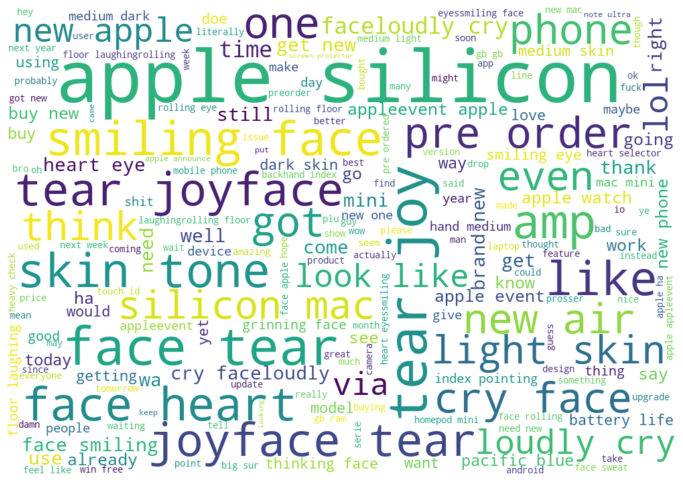

In [35]:
fig, ax = plt.subplots(figsize=(12,17))

wordcloud = WordCloud(width=1000, height=700, stopwords=stop_words, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()

## Apple logo wordcloud

In [36]:
import PIL
logo_mask = np.array(Image.open("images/apple-2962084_1920.png"))
logo_mask

fig, ax = plt.subplots(figsize=(15,15))
image_colors = ImageColorGenerator(logo_mask)

wc = WordCloud(background_color="white", max_words=100, width=400, height=400, mask=logo_mask, random_state=1).generate(text)
plt.imshow(wc.recolor(color_func=image_colors), interpolation='bilinear')
plt.axis("off")

plt.show()
plt.savefig('cloud1.png', bbox_inches= 'tight', format='png')

NameError: name 'Image' is not defined

# Random Forest (Baseline)

In [268]:
rf_feats = apple_df.c_tweet.values
rf_targets = apple_df.sentiment.values

In [155]:
tfidfconverter = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.7, stop_words=stop_words)  
X = tfidfconverter.fit_transform(rf_feats).toarray()

/Users/brendanferris/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['arrival', 'available', 'easter', 'egg', 'enter', 'help', 'huge', 'new', 'please', 'rt', 'sale', 'unlocked', 'us', 'visit', 'win'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [162]:
X_train, X_test, y_train, y_test = train_test_split(X, rf_targets, test_size=0.2, random_state=0)

In [269]:
from sklearn.ensemble import RandomForestClassifier
text_classifier = RandomForestClassifier(n_estimators=15, random_state=0)  
text_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=15, random_state=0)

In [270]:
preds = text_classifier.predict(X_test)

In [271]:
print("Accuracy is:", metrics.accuracy_score(preds, y_test))

Accuracy is: 0.8576358612219834


In [272]:
print(classification_report(preds, y_test))

              precision    recall  f1-score   support

    negative       0.61      0.82      0.70     11187
     neutral       0.95      0.83      0.88     33514
    positive       0.89      0.90      0.89     36724

    accuracy                           0.86     81425
   macro avg       0.82      0.85      0.83     81425
weighted avg       0.87      0.86      0.86     81425



In [206]:
text_classifier.predict(X[638].reshape(1, -1))

array(['negative'], dtype=object)

In [205]:
apple_df.iloc[638]

date                                            2020-11-29 00:00:00
name                                               King Ayush Goyal
username                                                 ayushg1394
retweets_count                                                    1
search_term                                           apple silicon
likes_count                                                       1
language                                                         en
c_tweet           am from india purchased iphone for st time but...
sentiment                                                  negative
cleaned           [am, from, india, purchased, iphone, for, st, ...
not_filtered      [india, purchased, st, time, worst, service, e...
filtered          india, purchased, st, time, worst, service, ex...
Name: 638, dtype: object

In [182]:
X[3]

array([0., 0., 0., ..., 0., 0., 0.])

In [248]:
made_up = tfidfconverter.transform(['I read the book it was 64 pages long']).toarray()

In [249]:
text_classifier.predict(made_up.reshape(1, -1))

array(['neutral'], dtype=object)

In [ ]:
print("Accuracy is:", classify.accuracy(classifier, test_data))

# Model 2

In [273]:
from sklearn.svm import SVC

In [ ]:
svm_classifier = SVC(class_weight='balanced', probability = True)

svm_classifier.fit(X_train, y_train)

In [ ]:
y_pred = svm_classifier.predict(X_test)

In [ ]:
print(classification_report(y_preds, y_test))